Loading and splitting the data

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../4. Data Preparation/featured_ads.csv')

In [3]:
df.drop('age', axis=1, inplace=True)

Note: dropped the age feature because its correlation with price was too low.

In [198]:
df.sample(5)

,rooms,total_price,elevator,parking,warehouse,total_price_log,outlier,address_encoded,region_1,region_2,...,region_13,region_14,region_15,region_16,region_17,region_18,region_19,region_20,region_21,region_22
972,2,8000000000,1,1,0,22.802707,0,9.511851e+09,0,0,...,0,0,0,0,0,0,0,0,0,0
424,2,10300000000,1,1,1,23.055410,0,1.020003e+10,0,0,...,0,0,0,0,0,0,0,0,0,0
1924,3,9200000000,1,1,1,22.942469,0,1.876026e+10,0,1,...,0,0,0,0,0,0,0,0,0,0
2335,2,2040000000,0,0,1,21.436216,0,3.610250e+09,0,0,...,0,0,0,0,0,0,0,0,0,0
6591,1,5500000000,0,1,1,22.428014,0,1.336613e+10,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9577 entries, 0 to 9576
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rooms            9577 non-null   int64  
 1   total_price      9577 non-null   int64  
 2   elevator         9577 non-null   int64  
 3   parking          9577 non-null   int64  
 4   warehouse        9577 non-null   int64  
 5   total_price_log  9577 non-null   float64
 6   outlier          9577 non-null   int64  
 7   address_encoded  9577 non-null   float64
 8   region_1         9577 non-null   int64  
 9   region_2         9577 non-null   int64  
 10  region_3         9577 non-null   int64  
 11  region_4         9577 non-null   int64  
 12  region_5         9577 non-null   int64  
 13  region_6         9577 non-null   int64  
 14  region_7         9577 non-null   int64  
 15  region_8         9577 non-null   int64  
 16  region_9         9577 non-null   int64  
 17  region_10     

In [199]:
# df['region'] = df[[f'region_{i}' for i in range(1, 23)]].idxmax(axis=1)
# df['region'] = df['region'].apply(lambda x: int(x.split('_')[1]))
# df.drop([f'region_{i}' for i in range(1, 23)], axis=1, inplace=True)
# df.info()

In [5]:
# normalize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])

In [6]:
from sklearn.model_selection import train_test_split
X = df.drop(['total_price', 'total_price_log'], axis=1)
y = df['total_price_log']

In [7]:
# 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [216]:
X_train.shape, X_test.shape

((6703, 28), (2874, 28))

In [30]:
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error

def parameter_search(model, parameters, X_train, X_test, y_train, y_test):
    """
    Finds the best parameters for the model using GridSearchCV and evaluates it.
    Assumes that the target variable `y` is log-transformed with np.log1p.

    Parameters:
    - model: The model to be tuned.
    - parameters: The parameter grid for GridSearchCV.
    - X_train: Training feature data.
    - X_test: Test feature data.
    - y_train: Training target data (log-transformed).
    - y_test: Test target data (log-transformed).

    Returns:
    - train_score: R² score on the training set.
    - test_score: R² score on the test set.
    - RMSE: Root Mean Squared Error on the test set (with log-transformation inverse).
    """
    
    # Set up GridSearchCV
    grid = GridSearchCV(model, 
                        param_grid=parameters, 
                        refit=True, 
                        cv=KFold(shuffle=True, random_state=1), 
                        n_jobs=-1)
    
    # Fit the model and get predictions
    grid_fit = grid.fit(X_train, y_train)
    y_train_pred = grid_fit.predict(X_train)
    y_pred = grid_fit.predict(X_test)
    
    # Calculate R² scores
    train_score = grid_fit.score(X_train, y_train)
    test_score = grid_fit.score(X_test, y_test)
    
    # Convert the predictions and true values back to the original scale
    y_pred_original = np.expm1(y_pred)  # Inverse of np.log1p
    y_test_original = np.expm1(y_test)  # Inverse of np.log1p

    # Calculate RMSE
    RMSE = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    
    model_name = str(model).split('(')[0]
    
    # Print the results
    print(f"The best parameters for {model_name} model are: {grid_fit.best_params_}")
    print(f"(R² score) in the training set is {train_score:0.2%} for {model_name} model.")
    print(f"(R² score) in the testing set is {test_score:0.2%} for {model_name} model.")
    print(f"RMSE is {RMSE:,.2f} for {model_name} model.")
    
    return train_score, test_score, RMSE

Linear Regression

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
lr = LinearRegression()
lr_parameters = {}
lr_train_score, lr_test_score, lr_RMSE = parameter_search(lr, lr_parameters, X_train, X_test, y_train, y_test)

The best parameters for LinearRegression model are: {}
(R² score) in the training set is 42.49% for LinearRegression model.
(R² score) in the testing set is 38.74% for LinearRegression model.
RMSE is 1.10 for LinearRegression model.


Ridge regression

In [12]:
from sklearn.linear_model import Ridge

In [13]:
ridge = Ridge()
ridge_parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
ridge_train_score, ridge_test_score, ridge_RMSE = parameter_search(ridge, ridge_parameters, X_train, X_test, y_train, y_test)

The best parameters for Ridge model are: {'alpha': 100}
(R² score) in the training set is 42.49% for Ridge model.
(R² score) in the testing set is 38.78% for Ridge model.
RMSE is 1.10 for Ridge model.


Lasso regression

In [14]:
from sklearn.linear_model import Lasso

In [15]:
lasso = Lasso()
lasso_parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
lasso_train_score, lasso_test_score, lasso_RMSE = parameter_search(lasso, lasso_parameters, X_train, X_test, y_train, y_test)

The best parameters for Lasso model are: {'alpha': 0.001}
(R² score) in the training set is 42.49% for Lasso model.
(R² score) in the testing set is 38.75% for Lasso model.
RMSE is 1.10 for Lasso model.


ElasticNet regression

In [16]:
from sklearn.linear_model import ElasticNet

In [17]:
elastic = ElasticNet(max_iter=10000)
elastic_parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                      'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
elastic_train_score, elastic_test_score, elastic_RMSE = parameter_search(elastic, elastic_parameters, X_train, X_test, y_train, y_test)

/home/mohadeseh/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.624e+00, tolerance: 5.245e-01
  model = cd_fast.enet_coordinate_descent(
/home/mohadeseh/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.086e-01, tolerance: 5.498e-01
  model = cd_fast.enet_coordinate_descent(
/home/mohadeseh/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

The best parameters for ElasticNet model are: {'alpha': 0.01, 'l1_ratio': 0.1}
(R² score) in the training set is 42.48% for ElasticNet model.
(R² score) in the testing set is 38.77% for ElasticNet model.
RMSE is 1.10 for ElasticNet model.


Decision Tree Regressor

In [18]:
from sklearn.tree import DecisionTreeRegressor

In [19]:
dt = DecisionTreeRegressor()
dt_parameters = {'max_depth': [None, 5, 10, 15, 20],
                 'min_samples_split': [2, 5, 10, 15, 20],
                 'min_samples_leaf': [1, 2, 4, 8, 16]}
dt_train_score, dt_test_score, dt_RMSE = parameter_search(dt, dt_parameters, X_train, X_test, y_train, y_test)

The best parameters for DecisionTreeRegressor model are: {'max_depth': 5, 'min_samples_leaf': 16, 'min_samples_split': 2}
(R² score) in the training set is 44.94% for DecisionTreeRegressor model.
(R² score) in the testing set is 40.14% for DecisionTreeRegressor model.
RMSE is 1.08 for DecisionTreeRegressor model.


Random Forest Regressor

In [20]:
from sklearn.ensemble import RandomForestRegressor

In [21]:
rf = RandomForestRegressor()
rf_parameters = {'n_estimators': [100, 200, 300],
                 'max_depth': [None, 5, 10, 15, 20],
                 'min_samples_split': [2, 5, 10, 15, 20],
                 'min_samples_leaf': [1, 2, 4, 8, 16]}
rf_train_score, rf_test_score, rf_RMSE = parameter_search(rf, rf_parameters, X_train, X_test, y_train, y_test)

The best parameters for RandomForestRegressor model are: {'max_depth': 20, 'min_samples_leaf': 16, 'min_samples_split': 15, 'n_estimators': 200}
(R² score) in the training set is 48.41% for RandomForestRegressor model.
(R² score) in the testing set is 42.13% for RandomForestRegressor model.
RMSE is 1.08 for RandomForestRegressor model.


XGBoost Regressor

In [22]:
from xgboost import XGBRegressor

In [23]:
xgb = XGBRegressor()
xgb_parameters = {'n_estimators': [100, 200, 300],
                  'max_depth': [3, 5, 7, 9],
                  'learning_rate': [0.01, 0.1, 0.3]}
xgb_train_score, xgb_test_score, xgb_RMSE = parameter_search(xgb, xgb_parameters, X_train, X_test, y_train, y_test)

The best parameters for XGBRegressor model are: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
(R² score) in the training set is 50.94% for XGBRegressor model.
(R² score) in the testing set is 40.30% for XGBRegressor model.
RMSE is 1.03 for XGBRegressor model.


SVM

In [31]:
from sklearn.svm import SVR

In [32]:
svm = SVR()
svm_parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                  'C': [0.1, 1, 10],
                  'epsilon': [0.1, 0.2, 0.5]}
svm_train_score, svm_test_score, svm_RMSE = parameter_search(svm, svm_parameters, X_train, X_test, y_train, y_test)

The best parameters for SVR model are: {'C': 10, 'epsilon': 0.2, 'kernel': 'rbf'}
(R² score) in the training set is 46.79% for SVR model.
(R² score) in the testing set is 42.25% for SVR model.
RMSE is 1.05 for SVR model.


Plotting the results

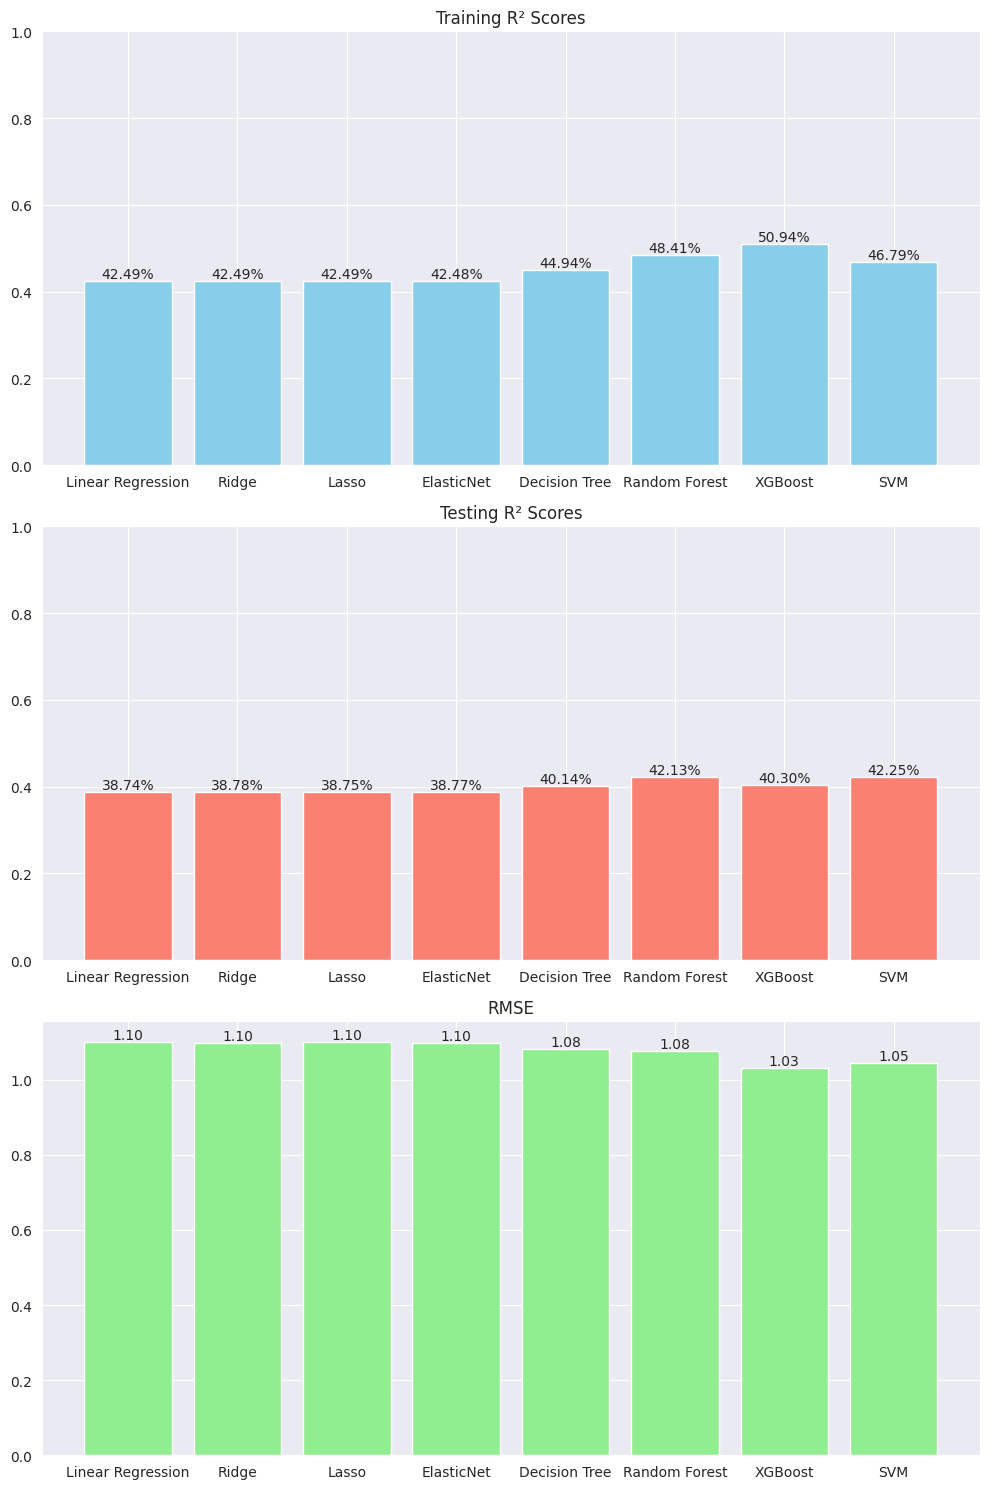

In [33]:
import matplotlib.pyplot as plt

models = ['Linear Regression', 'Ridge', 'Lasso', 'ElasticNet', 'Decision Tree', 'Random Forest', 'XGBoost', 'SVM']
train_scores = [lr_train_score, ridge_train_score, lasso_train_score, elastic_train_score, dt_train_score, rf_train_score, xgb_train_score, svm_train_score]
test_scores = [lr_test_score, ridge_test_score, lasso_test_score, elastic_test_score, dt_test_score, rf_test_score, xgb_test_score, svm_test_score]
RMSEs = [lr_RMSE, ridge_RMSE, lasso_RMSE, elastic_RMSE, dt_RMSE, rf_RMSE, xgb_RMSE, svm_RMSE]

fig, ax = plt.subplots(3, 1, figsize=(10, 15))

ax[0].bar(models, train_scores, color='skyblue')
ax[0].set_title('Training R² Scores')
ax[0].set_ylim(0, 1)
for i, score in enumerate(train_scores):
    ax[0].text(i, score, f'{score:0.2%}', ha='center', va='bottom')
    
ax[1].bar(models, test_scores, color='salmon')
ax[1].set_title('Testing R² Scores')
ax[1].set_ylim(0, 1)
for i, score in enumerate(test_scores):
    ax[1].text(i, score, f'{score:0.2%}', ha='center', va='bottom')
    
ax[2].bar(models, RMSEs, color='lightgreen')
ax[2].set_title('RMSE')
for i, RMSE in enumerate(RMSEs):
    ax[2].text(i, RMSE, f'{RMSE:,.2f}', ha='center', va='bottom')
    
plt.tight_layout()
plt.show()